# Разработка A/B-тестирования и анализ результатов

Компания разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу.

- Автор: Онищенко Надежда
- Дата:

## Цели и задачи проекта 
Рассчитать параметры A/B-теста, оценить корректность его проведения и проанализировать результаты эксперимента.

## Описание данных

Данные состоят из трех датасетов:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. 
- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14.
- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02.
- 
У этих таблиц в основном совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Описание таблиц:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

## Содержимое работы
1. Работа с историческими данными (EDA)
2. Подготовка к А/В-тесту
3. Мониторинг А/В-теста
4. Проверка результатов А/В-теста
5. Выводы

### Работа с историческими данными (EDA)

На первом этапе поработаем с историческими данными приложения:

- Ознакомимся с данными и сохраним в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.
- Проанализируем число регистраций пользователей
- Проанализирем число просматриваемых страниц

#### Загрузка и ознакомление с историческими данными

- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.
- Выведим все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберим любого из них.
- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.

In [2]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Выгружаем данные в переменную sessions_history
sessions_history = pd.read_csv(r'C:\Users\dima_\Desktop\Данные\sessions_project_history.csv')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
# Рассчитаем количество уникальных сессий
session_id = sessions_history.groupby('user_id')['session_id'].nunique().reset_index()
display(session_id.head())

,user_id,session_id
0,00005FB6A13A6FBE,2
1,0000B15A18D77ED9,3
2,0000C4E3A4A571A9,2
3,000293FAF9E67A81,4
4,00029C5AE889A6C3,2


In [4]:
# Выведем данные одного пользователя с наибольшим количеством сессий
max_user_sessions = sessions_history[sessions_history['user_id']==session_id['user_id'].loc[session_id['session_id'].idxmax()]]
display(max_user_sessions)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### **Анализ числа регистраций**

Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты посчитаем, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.
- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразим их на одном графике.
- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [5]:
# Рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдений
sessions_agg = sessions_history.groupby('session_date').agg({'user_id':'nunique', 'registration_flag':'sum'}).reset_index()
sessions_agg.columns = ['session_date', 'user_count', 'user_reg_count']
display(sessions_agg.head())

,session_date,user_count,user_reg_count
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840


In [6]:
# расчитаем отношение зарегистрированных пользователей к уникальным
round(sessions_agg['user_reg_count'].sum() / sessions_agg['user_count'].sum(), 2)

0.08

- Визуализируем данные с помощью линейных графиков

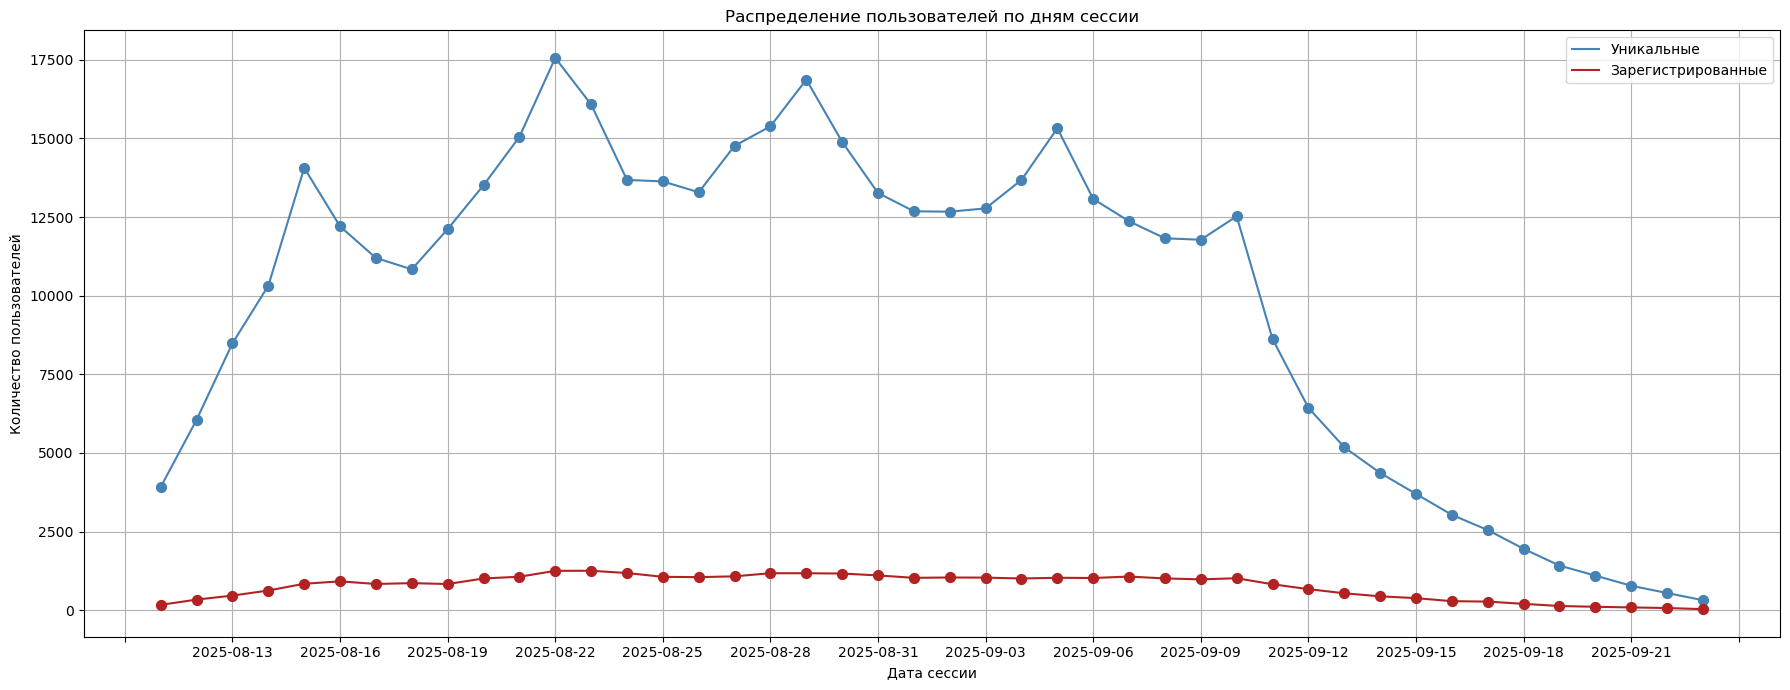

In [7]:
import matplotlib.dates as mdates

# Создаем график
fig, ax = plt.subplots(figsize=(18, 7))

line1 = ax.plot(sessions_agg['session_date'], sessions_agg['user_count'], label='Уникальные', color='steelblue') # Создаем линии
line2 = ax.plot(sessions_agg['session_date'], sessions_agg['user_reg_count'], label='Зарегистрированные', color='firebrick')

ax.set_title('Распределение пользователей по дням сессии')
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Дата сессии')
ax.legend()

# Форматируем ось X для улучшения читаемости
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Каждые 1 день

# Добавляем точки на график
ax.scatter(sessions_agg['session_date'], sessions_agg['user_count'], color='steelblue', s=50, zorder=5) 
ax.scatter(sessions_agg['session_date'], sessions_agg['user_reg_count'], color='firebrick', s=50, zorder=5)

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.tight_layout() # Настроим отступы
plt.show()

***По результатам исследования можно сказать следующее:***

- Можно сказать, что графики имеют примерно нормальное распределение с некоторым смещением.

- За первый период (с 11.08 по 10.09), около двух третей данных наблюдается резкий рост количества уникальных пользователей приложения — с 3919 до 12526. При этом число зарегистрированных пользователей растет значительно медленнее (от 169 до 1015), показывая более плавный прирост.

- Во втором периоде (с 11.09 по 23.09), оба графика демонстрируют снижение значений. Уникальные пользователи падают более резко — с 8623 до 317, а зарегистрированные — с 824 до 32. Это отмечает снижение активности в конце периода.

- Среднее отношение зарегистрированных пользователей к дневному количеству уникальных пользователейских сессий составляет лишь около 0,08, что свидетельствует о крайне низкой мотивации пользователей проходить регистрацию.

- Визуализируем данные доли зарегистрированных пользователей от всех пользователей по дням, также линейным графиком с добавлением скользящей средней

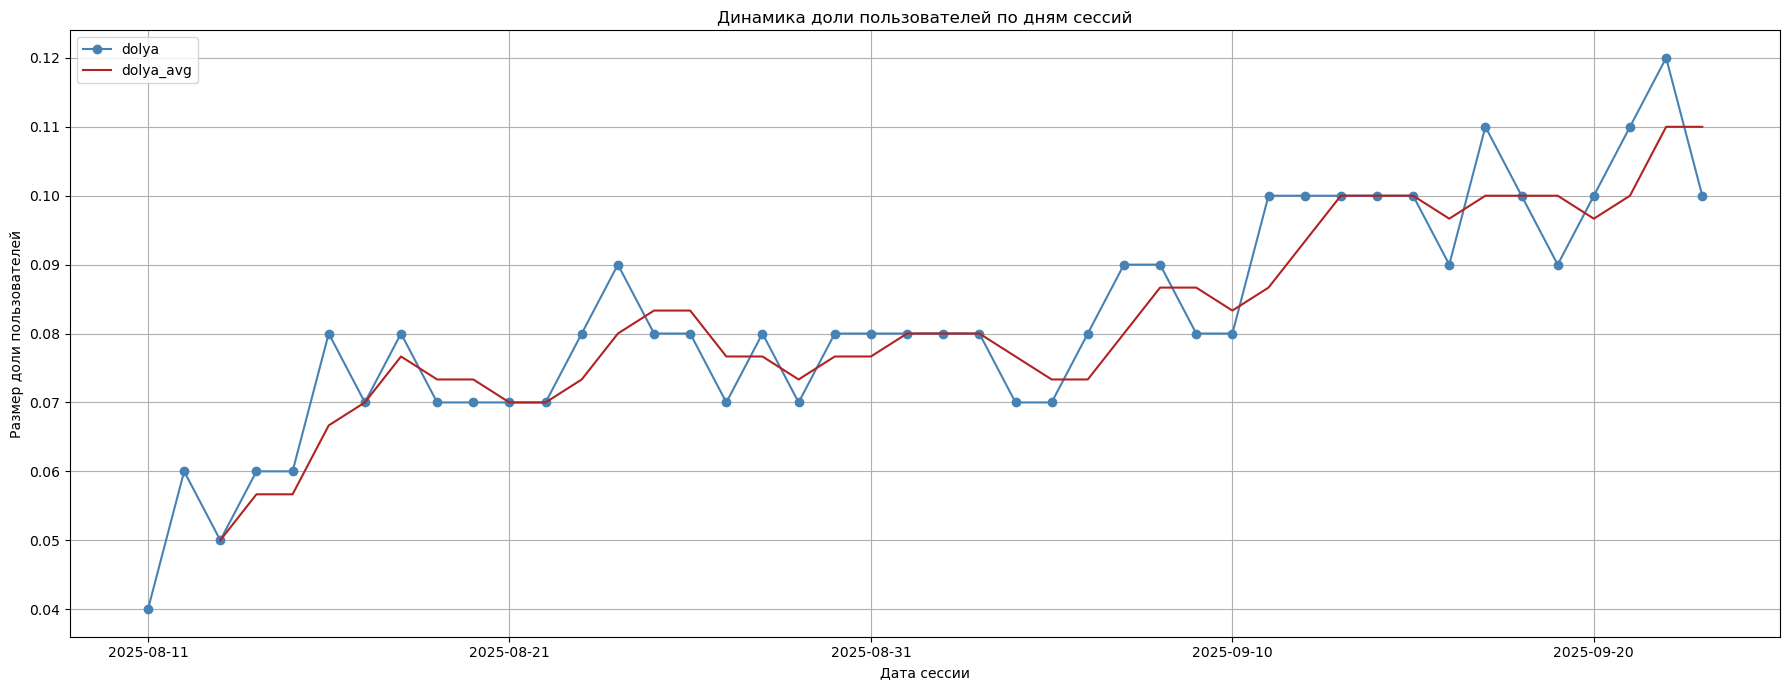

In [8]:
sessions_agg['dolya'] = round(sessions_agg['user_reg_count']/sessions_agg['user_count'], 2)

# Добавляем расчет скользящей средней
sessions_agg['dolya_avg'] = sessions_agg['dolya'].rolling(window=3).mean()

# Строим график
sessions_agg.plot(kind='line',
                         x='session_date',
                         y='dolya',
                         legend=True,
                         title='Динамика доли пользователей по дням сессий',
                         color='steelblue',
                         marker='o', # Установка маркера для точек 
                         figsize=(18, 7),
                         grid=True)

# Строим график скользящей средней
sessions_agg.plot(kind='line',
                         x='session_date',
                         y='dolya_avg',
                         legend=True,
                         color='firebrick',
                         ax=plt.gca())

# Устанавливаем названия по осям
plt.xlabel('Дата сессии')
plt.ylabel('Размер доли пользователей')

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.tight_layout() # Настроим отступы
plt.show()

***По результатам исследования можно сказать следующее:***

- Исходя из графика видим прирост доли зарегестрированных пользователей от 0,04 до максимального значения за исследуемый период 0,12
- Линейный график доли зарегестрированных пользователей в этих пределах выглятит динамичным со стремление к росту, но в общем сам рост составляет всего 8% с падением в конце рассматриваемого периода.

#### **Анализ числа просмотренных страниц**

Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.
- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

In [9]:
# Проверим наличие пропусков в столбце page_counter
sessions_history['page_counter'].isna().sum()

0

In [10]:
# Расчитаем количество сессий для каждого значения количества просмотренных страниц
sessions_history['page_counter'].value_counts().reset_index().style.background_gradient(cmap='coolwarm', axis=0)

,page_counter,count
0,3,166690
1,4,105569
2,2,105536
3,1,29160
4,5,26288
5,6,2589
6,7,92


- Визуализируем данные с помощью столбчатой диаграммы

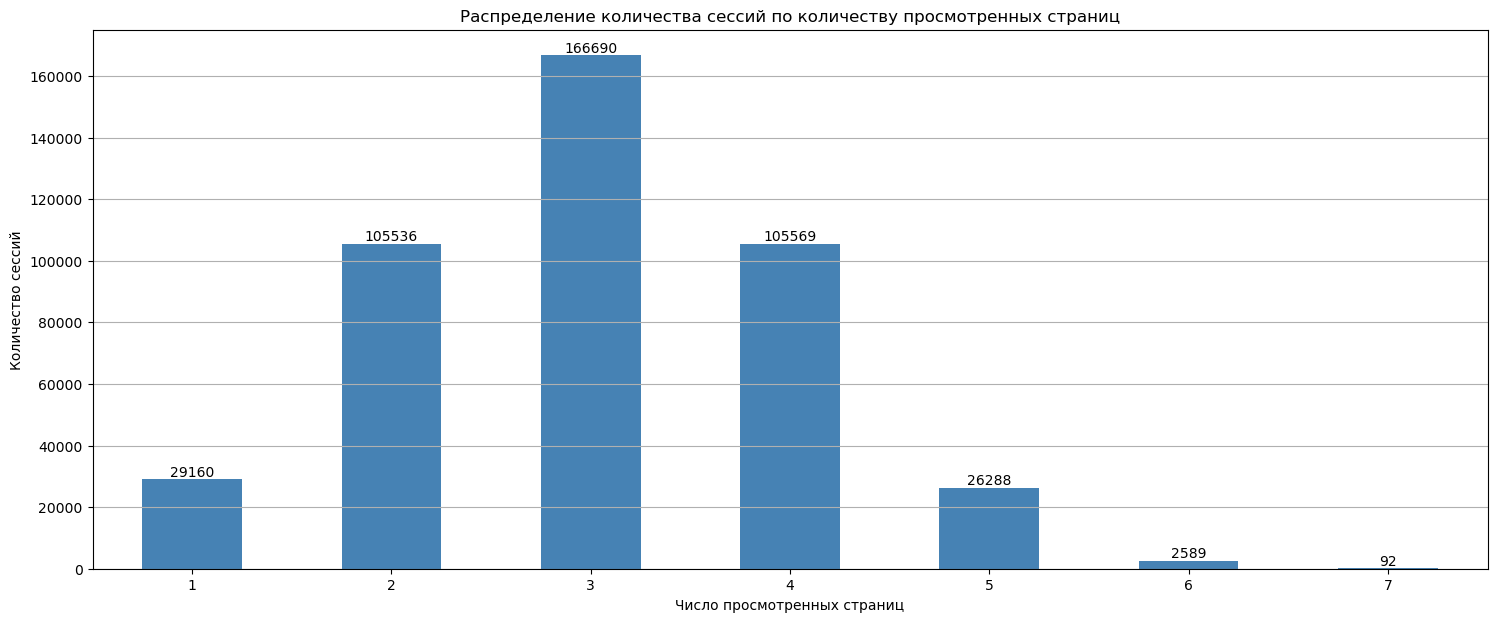

In [11]:
# Создаем переменную данных
page_count = sessions_history['page_counter'].value_counts(ascending=True)

# Убедимся, что индексы от 1 до 7
page_count = page_count.reindex(range(1, 8), fill_value=0)

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(18, 7))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
page_count.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               color='steelblue',
               title=f'Распределение количества сессий по количеству просмотренных страниц'
)

# Добавляем значения на график
for index, value in enumerate(page_count):
    plt.text(index, value, str(value), ha='center', va='bottom')
    
# Настраиваем оформление графика
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')

# Добавляем сетку графика
plt.grid(axis='y')

# Выводим график
plt.show()

***По результатам исследования можно сказать следующее:***

- Исходя из диаграммы наибольшее количество сессий приходится на 2-4 просмотренных страниц, минимальное количество сессий на 6-7 страниц

##### **Доля пользователей, просмотревших более четырёх страниц**

Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.
- Построим график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [12]:
# Создадим столбец `good_session` с помощью функции create_sessions

def create_sessions(x):
    if x>=4:
        return 1
    return 0
    
sessions_history['good_session'] = sessions_history['page_counter'].apply(create_sessions)

In [13]:
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


In [14]:
sessions_good = sessions_history.groupby('session_date')['good_session'].agg(['count', 'sum']).reset_index()
sessions_good.columns = ['session_date', 'good_count', 'good_sum']
display(sessions_good.head())

,session_date,good_count,good_sum
0,2025-08-11,3919,1226
1,2025-08-12,6056,1829
2,2025-08-13,8489,2604
3,2025-08-14,10321,3262
4,2025-08-15,14065,4289


In [15]:
# расчитаем отношение успешных сессий к общему количеству сессий
round(sessions_good['good_sum'].sum() / sessions_good['good_count'].sum(), 2)

0.31

- Визуализируем данные с помощью линейного графика

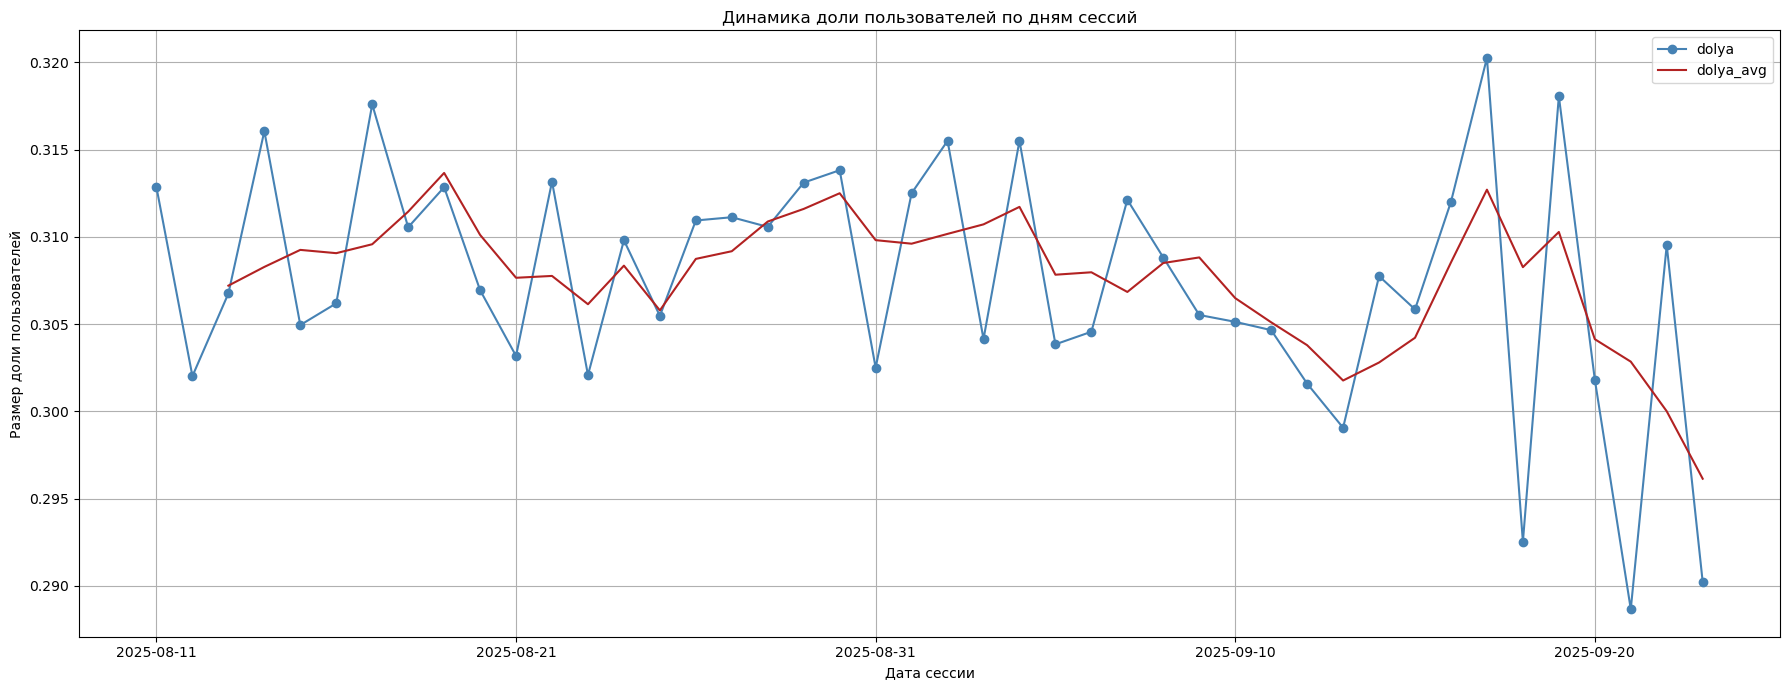

In [16]:
sessions_good['dolya'] = sessions_good['good_sum']/sessions_good['good_count']

# Добавляем расчет скользящей средней
sessions_good['dolya_avg'] = sessions_good['dolya'].rolling(window=3).mean()

# Строим график
sessions_good.plot(kind='line',
                         x='session_date',
                         y='dolya',
                         legend=True,
                         title='Динамика доли пользователей по дням сессий',
                         color='steelblue',
                         marker='o', # Установка маркера для точек 
                         figsize=(18, 7),
                         grid=True)

# Строим график скользящей средней
sessions_good.plot(kind='line',
                         x='session_date',
                         y='dolya_avg',
                         legend=True,
                         color='firebrick',
                         ax=plt.gca())

# Устанавливаем названия по осям
plt.xlabel('Дата сессии')
plt.ylabel('Размер доли пользователей')

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.tight_layout() # Настроим отступы
plt.show()

***По результатам исследования можно сказать следующее:***

- Успешных сессий, тех в которых было просмотренно 4 и более страниц, составляют 30% от всех сессий
- Линейный график доли успешных секций динамичен в пределах от 0,29 до 0,32 со стремлением к падению. Но в общем можно сказать,  что показатель стабилен в расстатриваемом периоде, так как разброс показателя всего 3%

### Подготовка к тесту

При планировании теста необходимо проделать несколько важных шагов:

- Определимся с целевой метрикой.
- Рассчитаем необходимый размер выборки.
- Исходя из текущих значений трафика, рассчитаем необходимую длительность проведения теста.

#### Расчёт размера выборки

Установим в коде ниже следующие параметры:

- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Мощность теста.
- Минимальный детектируемый эффект, или MDE, — 3%.

При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [17]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.
- Определим длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлим в большую сторону.

In [18]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round((sessions_history.groupby('session_date')['user_id'].nunique()).mean(), 0)
                       
# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/(avg_daily_users)) # умножили выборку на 2, так как нужнго набрать на 2 группы

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.0 пользователей в день составит 4 дней


### Мониторинг А/В-теста

#### Проверка распределения пользователей

- Считаем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.
- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.
- Рассчитаем и выведем процентную разницу в количестве пользователей в группах A и B. Построим любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [19]:
# Выгружаем данные в переменную sessions_test_part
sessions_test_part = pd.read_csv(r'C:\Users\dima_\Desktop\Данные\sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [20]:
# Проверим данные, убедимся в единственной дате
sessions_test_part['session_date'].unique()

array(['2025-10-14'], dtype=object)

In [21]:
# Расчитаем количество уникальных пользователей группы А
users_A = sessions_test_part[sessions_test_part['test_group']=='A']['user_id'].nunique()
print(users_A)

1477


In [22]:
# Расчитаем количества уникальных пользователей группы В 
users_B = sessions_test_part[sessions_test_part['test_group']=='B']['user_id'].nunique()
print(users_B)

1466


In [23]:
# Расчитаем процентную разницу
P = round((100*abs(users_A-users_B))/users_A, 2)
print(P)

0.74


- Визуализируем данные с помощью круговой диаграммы

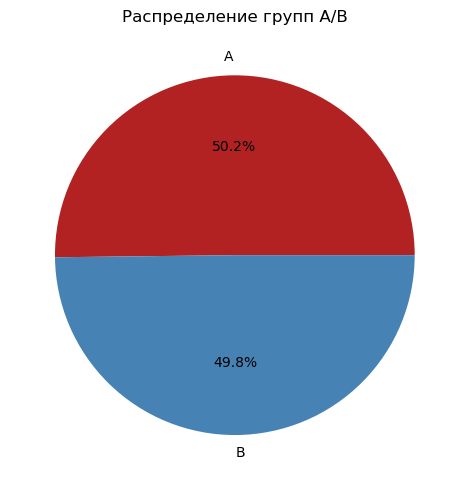

In [24]:
# Создаем переменную данных
sessions_groups = sessions_test_part.groupby('test_group')['user_id'].nunique()

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(18, 5))

# Список цветов
colors = ['firebrick', 'steelblue']

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
axes = sessions_groups.plot( # переведем в проценты
               kind='pie', # Тип графика - столбчатая диаграмма
               autopct = '%1.1f%%',
               legend=False, # Выключаем легенду
               colors=colors[:len(sessions_groups)],
               title=f'Распределение групп А/В'
)

# Настраиваем оформление графика
plt.ylabel('')

# Поворот графика
axes.set_aspect('equal')

# Выводим график
plt.tight_layout() # Настроим отступы
plt.show()

***По результатам исследования можно сказать следующее:***

- Исходя из диаграммы видим равенство групп

#### Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [25]:
# Выдедем пользователей групп А и В
users_A = sessions_test_part[sessions_test_part['test_group']=='A']['user_id']
users_B = sessions_test_part[sessions_test_part['test_group']=='B']['user_id']

In [26]:
# преобразуем в датафреймы
df_A = pd.DataFrame(users_A)
df_B = pd.DataFrame(users_B)

In [27]:
# Проверим наличие пользователей попавших в обе группы
users_common = len(df_A[df_A['user_id'].isin(df_B['user_id'])])
display(users_common)

0

***По результатам исследования можно сказать следующее:***

- Пользователей, одновременно встречающихся в группах А и В не обнаружено

#### Равномерность разделения пользователей по устройствам

Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,
- доля каждого типа устройства для пользователей из группы B.

In [28]:
# Создатим таблицу с расчетом количества пользователей для каждого типа устройств по группам А и В
test_part_dev = sessions_test_part.pivot_table(index='device', 
                                               columns='test_group', 
                                               values='user_id', 
                                               aggfunc='nunique', 
                                               margins=True, 
                                               margins_name='Итого')
display(test_part_dev)

test_group,A,B,Итого
device,,,
Android,656,668,1324
Mac,156,148,304
PC,369,381,750
iPhone,296,269,565
Итого,1477,1466,2943


- Визуализируем данные с помощью вертикальной столбчатой диаграммы

<Figure size 1800x700 with 0 Axes>

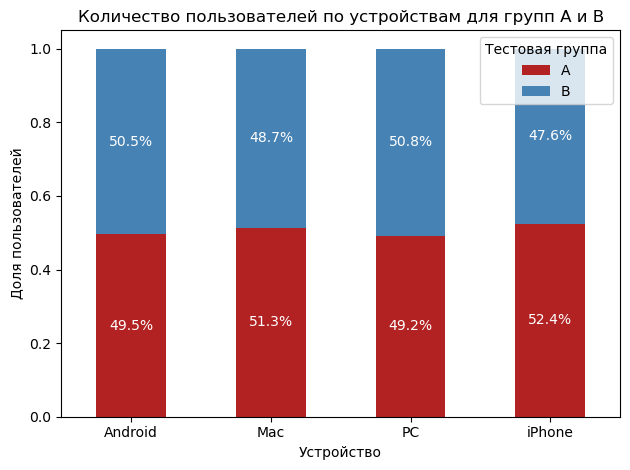

In [29]:
# Откорректируем данные
df = test_part_dev[['A', 'B']]
df = df.drop(index='Итого')

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(18, 7))

# Нормализуем данные
df_normalized = df.div(df.sum(axis=1), axis=0)

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
ax = df_normalized.plot(kind='bar', # Тип графика - столбчатая диаграмма
               stacked=True,
               rot=0, # Градус вращения подписи по оси Х
               legend=True, # Выключаем легенду
               title=f'Количество пользователей по устройствам для групп A и B',
                 color=['firebrick', 'steelblue']
              )

# Добавляем значения процентов на график
for i in range(len(df_normalized)):
    total_height = df_normalized.iloc[i].sum()
    cumulative_height = 0  # Сумма высоты до текущего сегмента
    
    for j in range(len(df_normalized.columns)):
        value = df_normalized.iloc[i, j]
        cumulative_height += value
        
        # Вычисляем позицию для текста (по центру сегмента)
        y_position = cumulative_height - value / 2
        
        # Добавляем текст с процентами
        ax.text(i, y_position, f'{value:.1%}', ha='center', va='center', color='white')

# Настраиваем оформление графика
plt.xlabel('Устройство')
plt.ylabel('Доля пользователей')
plt.legend(title='Тестовая группа')

# Добавляем сетку графика
plt.grid(False)

# Выводим график
plt.tight_layout() # Настроим отступы
plt.show()

***По результатам исследования можно сказать следующее:***

- Исходя из диаграммы видим расхождения в группах: минимальное 0,1% на устройстве Android и максимальное 4,8% на iPhone
- Можно считать, что пользователи равномерно распределены по устройствам

#### Равномерность распределения пользователей по регионам

Теперь убедимся, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,
- доля каждого региона для пользователей из группы B.

In [30]:
# Создатим таблицу с расчетом количества пользователей для каждого региона по группам А и В
test_part_reg = sessions_test_part.pivot_table(index='region', 
                                               columns='test_group', 
                                               values='user_id', 
                                               aggfunc='nunique', 
                                               margins=True, 
                                               margins_name='Итого')
display(test_part_reg)

test_group,A,B,Итого
region,,,
CIS,644,645,1289
EU,224,217,441
MENA,609,604,1213
Итого,1477,1466,2943


- Визуализируем данные с помощью горизонтальной столбчатой диаграммы

<Figure size 1800x700 with 0 Axes>

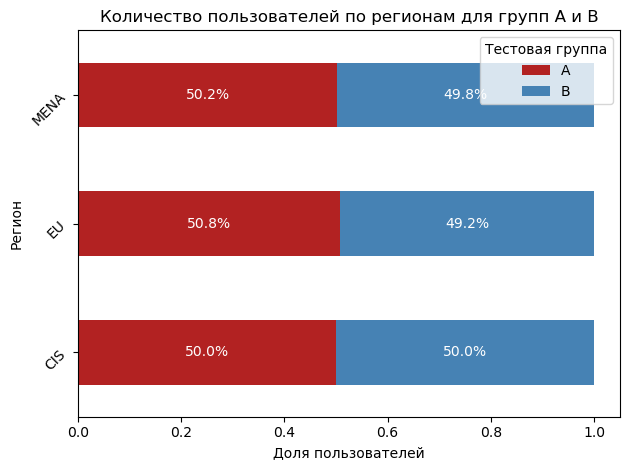

In [31]:
# Откорректируем данные
df_2 = test_part_reg[['A', 'B']]
df_2 = df_2.drop(index='Итого')

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(18, 7))

# Нормализуем данные
# Нормализуем данные
df_normalized = df_2.div(df_2.sum(axis=1), axis=0)

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
ax = df_normalized.plot(kind='barh', # Тип графика - столбчатая диаграмма
               stacked=True,
               rot=45, # Градус вращения подписи по оси Х
               legend=True, # Выключаем легенду
               title=f'Количество пользователей по регионам для групп A и B',
                 color=['firebrick', 'steelblue']
              )

# Добавляем значения процентов на график
for i in range(len(df_normalized)):
    total_width = df_normalized.iloc[i].sum()
    cumulative_width = 0  # Сумма ширины до текущего сегмента
    
    for j in range(len(df_normalized.columns)):
        value = df_normalized.iloc[i, j]
        cumulative_width += value
        
        # Вычисляем позицию для текста (по центру сегмента)
        x_position = cumulative_width - value / 2
        
        # Добавляем текст с процентами
        ax.text(x_position, i, f'{value:.1%}', ha='center', va='center', color='white')

# Настраиваем оформление графика
plt.xlabel('Доля пользователей')
plt.ylabel('Регион')
plt.legend(title='Тестовая группа')

# Добавляем сетку графика
plt.grid(False)

# Выводим график
plt.tight_layout() # Настроим отступы
plt.show()

***По результатам исследования можно сказать следующее:***

- Исходя из диаграммы видим расхождения в группах: минимальное 0,0% в регионе CIS и максимальное 1,6% в в регионе EU
- Можно считать, что пользователи равномерно распределены по регионам

#### Предварительный вывод после проверки A/B-теста

- Расхождение количества потребителей между группами А и В минимально и составляет 0,4 % (или 11 потребителей). Расчетная процентрая разница равна 0,74;
- Пересечения пользователей тестовой и контрольной групп не обнаружено;
- Распределение долей пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам, демострирует расходения от 0,1 до 4,8 %, т.е. можно считать, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

### Проверка результатов A/B-теста

Убедимся в корректности теста и верно ли интерпретировать результаты.

#### Получение результатов теста и подсчёт основной метрики

- Считаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.
- В датафрейме `sessions_test` создим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [32]:
# Выгружаем данные в переменную sessions_test
sessions_test = pd.read_csv(r'C:\Users\dima_\Desktop\Данные\sessions_project_test.csv')

In [33]:
# Создадим столбец `good_session` с помощью функции create_sessions

def create_sessions(x):
    if x>=4:
        return 1
    return 0
    
sessions_test['good_session'] = sessions_test['page_counter'].apply(create_sessions)

In [34]:
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### Проверка корректности результатов теста

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.
- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.
- В качестве ответа выведим полученное значение p-value и интерпретируем его.

In [35]:
# Создатим таблицу с расчетом количества уникальных сессий для каждого дня по группам А и В
new_test = sessions_test.pivot_table(index='session_date', 
                                     columns='test_group', 
                                     values='session_id', 
                                     aggfunc='nunique', 
                                     margins=True, 
                                     margins_name='Итого')
display(new_test.head())

test_group,A,B,Итого
session_date,,,
2025-10-14,1502,1628,3130
2025-10-15,2235,2283,4518
2025-10-16,3280,3241,6521
2025-10-17,4089,4054,8143
2025-10-18,5013,5059,10072


- Визуализируем данные с помощью вертикальной столбчатой диаграммы

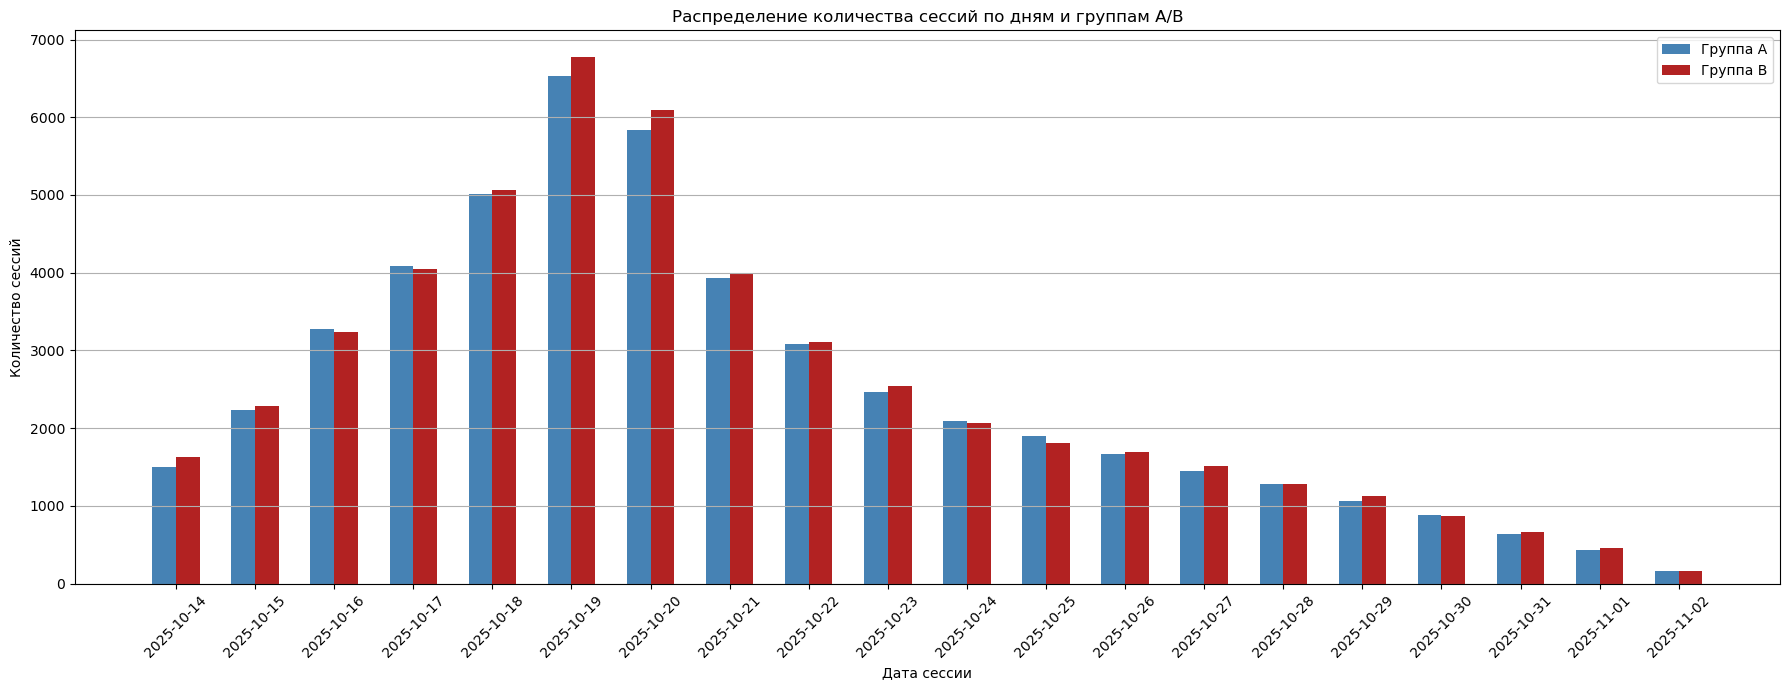

In [36]:
# Отберем только доли
df_3 = new_test[['A', 'B']]
df_3 = df_3.drop(index='Итого')

# Параметры графика
width = 0.3
session_date = list(df_3.index)
x = range(len(session_date))

# Создаем график
fig, ax = plt.subplots(figsize=(18, 7))

bar1 = ax.bar(x, df_3['A'], width, label='Группа А', color='steelblue') # Создаем столбцы
bar2 = ax.bar([i + width for i in x], df_3['B'], width, label='Группа B', color='firebrick')

ax.set_title('Распределение количества сессий по дням и группам А/В')
ax.set_ylabel('Количество сессий')
ax.set_xlabel('Дата сессии')
ax.set_xticks([i + width / 2 for i in x])  # Центрируем метки по оси X
ax.set_xticklabels(session_date, rotation=45)
ax.legend()

# Значения на графике выглядят излишне

# Добавляем сетку графика
plt.grid(axis='y')

# Выводим график
plt.tight_layout() # Настроим отступы
plt.show()

***По результатам исследования можно сказать следующее:***

- Исходя из диаграммы видим минимальные расхождения в группах по дням сессий

---

**Для проверки данных формулируем гипотезы:**
- Нулевая гипотеза (Ho): Выборочные средние в группах A и B равны
- Альтернативная гипотеза (Н1): Выборочные средние в группах A и B не равны

In [37]:
from scipy.stats import ttest_ind

# Выборка средних заказов для группы А
metric_a = df_3['A']
# Выборка средних заказов для группы B
metric_b = df_3['B']

alpha = 0.05 # установим уровне значимости, проверяем гипотезу о равенстве выборочных средних

stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    equal_var=False,
    alternative='two-sided' ## поскольку альтернативная гипотеза о том, что выборочное среднее первой выборки (metric_a) меньше второй выборки
) ## применяем t-тест Уэлча

if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
else:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны')

p-value теста Уэлча = 0.94
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны


***По результатам исследования можно сказать следующее:***

- p-value теста Уэлча больше уровня применяемого значимости, что укрепляет уверенность в истинности нулевой гипотезы. Это означает, что выборочные средние в группах A и B статистически равны. 
- Интерпретация: количество сессий не увеличилось после создания разработчиками нового алгоритма рекомендаций контента в приложении.

#### Сравнение доли успешных сессий

Используем созданный на первом шаге задания столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе. 

In [38]:
# Расчитаем доли успешных сесссий по группе А
share_good_session_A = round(sessions_test[sessions_test['test_group']=='A']['good_session'].mean(), 4)
display(share_good_session_A)

0.3077

In [39]:
# Расчитаем доли успешных сесссий по группе В
share_good_session_B = round(sessions_test[sessions_test['test_group']=='B']['good_session'].mean(), 4)
display(share_good_session_B)

0.3183

In [40]:
# Разница показателей, %
round(abs(share_good_session_A-share_good_session_B)*100, 1)

1.1

#### Насколько статистически значимо изменение ключевой метрики

- Используем статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.
- Выведем на экран полученное значение p-value и свои выводы о статистической значимости. Помним, что уровень значимости в эксперименте был выбран на уровне 0.05.

---

**Для проверки данных формулируем гипотезы:**
- Нулевая гипотеза (Ho): Доли успешных сессий в группах A и B равны
- Альтернативная гипотеза (Н1): Доли успешных сессий в группах A и B не равны

In [41]:
from statsmodels.stats.proportion import proportions_ztest

# посчитаем размер группы A
n_a = sessions_test[sessions_test['test_group']=='A']['good_session'].shape[0]
# посчитаем размер группы В
n_b = sessions_test[sessions_test['test_group']=='B']['good_session'].shape[0] 

# посчитаем кол-во успехов в группе A
m_a = sessions_test[(sessions_test.test_group=='A')&(sessions_test.good_session==1)].shape[0]
# посчитаем кол-во успехов в группе B
m_b = sessions_test[(sessions_test.test_group=='B')&(sessions_test.good_session==1)].shape[0]

p_a, p_b = m_a/n_a, m_b/n_b # посчитаем доли успехов для каждой группы: A и B

# проверим предпосылку о достаточном количестве данных
if (p_a*n_a>10)and((1-p_a)*n_a>10)and(p_b*n_b>10)and((1-p_b)*n_b>10): 
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

# установим уровень значимости
alpha = 0.05 

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='two-sided'
)

# выведим полученное p-value
print(f'p-value z-теста = {p_value_ztest}')

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
    print('Доли успешных сессий в группах А и В равны')
else:
    print('Нулевая гипотеза не находит подтверждения!')
    print('Доли успешных сессий в группах A и B не равны')

Предпосылка о достаточном количестве данных выполняется!
p-value z-теста = 0.0003149479976072246
Нулевая гипотеза не находит подтверждения!
Доли успешных сессий в группах A и B не равны


**!** Так как гипотеза о равности опровергнута, выдвинем новую гипотезу, что внедряемое нововведение будет иметь больше успешных результатов

**Для проверки данных формулируем гипотезы:**
- Нулевая гипотеза (Ho): Доли успешных сессий в группах A и B равны
- Альтернативная гипотеза (Н1): Доли успешных сессий в группе B > А

In [42]:
from statsmodels.stats.proportion import proportions_ztest

# посчитаем размер группы A
n_a = sessions_test[sessions_test['test_group']=='A']['good_session'].shape[0]
# посчитаем размер группы В
n_b = sessions_test[sessions_test['test_group']=='B']['good_session'].shape[0] 

# посчитаем кол-во успехов в группе A
m_a = sessions_test[(sessions_test.test_group=='A')&(sessions_test.good_session==1)].shape[0]
# посчитаем кол-во успехов в группе B
m_b = sessions_test[(sessions_test.test_group=='B')&(sessions_test.good_session==1)].shape[0]

p_a, p_b = m_a/n_a, m_b/n_b # посчитаем доли успехов для каждой группы: A и B

# проверим предпосылку о достаточном количестве данных
if (p_a*n_a>10)and((1-p_a)*n_a>10)and(p_b*n_b>10)and((1-p_b)*n_b>10): 
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

# установим уровень значимости
alpha = 0.05 

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

# выведим полученное p-value
print(f'p-value z-теста = {p_value_ztest}')

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
    print('Доли успешных сессий в группах А и В равны')
else:
    print('Нулевая гипотеза не находит подтверждения!')
    print('Доли успешных сессий в группе B больше, чем в группе А')

Предпосылка о достаточном количестве данных выполняется!
p-value z-теста = 0.0001574739988036123
Нулевая гипотеза не находит подтверждения!
Доли успешных сессий в группе B больше, чем в группе А


***По результатам исследования можно сказать следующее:***

- Принимается альтернативная гипотеза, о том что доля успешных сессий в группе В больше чем в контрольной группе А
- Интерпретация: доля успешных сессий увеличилась после создания разработчиками нового алгоритма рекомендаций контента в приложении.

### Вывод по результатам A/B-эксперимента

- В ходе проведенного экперименты были применены тест Уэлча для количесва уникальных сессий и Z-тест для пропорций доли успешных сессий
- Выборка для групп А и В составила 17 441 сессий и при текущем уровене трафика в 9 907 пользователей в день продолжительность эксперимента составила 4 дня
- Внедрение нового алгоритма рекомендаций не повлияло на количество сессий пользователей, но привело к учеличению доли успешных сессий 
- p-value теста Уэлча для количесва уникальных сессий = 0.94, что больше статистического уровня значимости 0,05, что говорит о том, что количество сессий не увеличилось после создания разработчиками нового алгоритма рекомендаций контента в приложении
- p-value z-теста для доли успешных = 0.0003, что меньше уровня значимости 0,05, что говорит о том, что доли успешных сессий в контрольной и тестовой группе не равны, а значит внедрение нового алгоритма рекомендаций повлияло на контрольную метрику
- p-value z-теста = 0.0001, что меньше уровня значимости 0,05, что подтвержает, что внедрение нового алгоритма рекомендачий увеличило долу успешных сессий в тестируемой группе.

**Вывод-рекомендации:**

Внедрение нового алгоритма рекомендаций не привело к увеличению общего количества сессий пользователей. Однако, наблюдается положительное влияние на среднее количество просматриваемых страниц пользователями в течение одной сессии. Это свидетельствует о том, что цель нового алгоритма — улучшение качества рекомендаций контента для каждого пользователя — была достигнута.
Таким образом, несмотря на отсутствие роста в количестве сессий, улучшение взаимодействия пользователей с контентом подтверждает эффективность нового алгоритма. В связи с этим, внедрение нового алгоритма можно считать оправданным!